In [1]:
pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from skimage import io
import torch
import torch.nn as nn
from PIL import Image
from skimage.transform import resize
import numpy as np
from tqdm import tqdm
from transformers import ViTMAEModel, ViTHybridModel, AutoImageProcessor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
f = open('/content/drive/MyDrive/BreaKHis_v1/ims400_RGB.npy', 'rb')
f1 = open('/content/drive/MyDrive/BreaKHis_v1/labs400_RGB.npy', 'rb')
df = pd.DataFrame(columns = ['img','labs'])
i = 0

while True:
    try:
        a = np.load(f)
        b = np.load(f1)
        df.loc[i] = [a,b]
        i+=1
    except:
        break

del f
del f1

In [8]:
print(df)

                                                     img labs
0      [[[0.54817593, 0.61714774, 0.6563046, 0.700197...  [1]
1      [[[0.4401589, 0.46550873, 0.49125117, 0.523715...  [1]
2      [[[0.61206704, 0.6606283, 0.6539628, 0.6593919...  [1]
3      [[[0.57067037, 0.5652294, 0.43867135, 0.297807...  [1]
4      [[[0.72389543, 0.81156576, 0.8357878, 0.846747...  [1]
...                                                  ...  ...
12315  [[[0.51100713, 0.5895159, 0.62304777, 0.665998...  [0]
12316  [[[0.33847454, 0.310669, 0.37219572, 0.4384335...  [1]
12317  [[[0.56471306, 0.58147556, 0.5495738, 0.503301...  [0]
12318  [[[0.77754235, 0.8018373, 0.6840394, 0.3942294...  [0]
12319  [[[0.5485379, 0.5686009, 0.5631602, 0.5521788,...  [1]

[12320 rows x 2 columns]


In [9]:
class BreastCancerDataset(Dataset):
    def __init__(self, dataframe):
        self.annotations = dataframe
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):

        image = torch.tensor(self.annotations.iloc[index, 0])
        # print(type(image))
        image = image_processor(image, return_tensors="pt")
        image = image['pixel_values'][0]
        y_label=torch.tensor(int(self.annotations.iloc[index, 1]))
            
        return (image, y_label)

In [10]:
dataset = BreastCancerDataset(df)
train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
print(len(dataset))

12320


In [11]:
batchsize=1
train_loader=DataLoader(train_set, batch_size=batchsize, shuffle=True)
test_loader=DataLoader(test_set, batch_size=batchsize, shuffle=True)

device=torch.device('cuda') if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()

True

In [15]:
#ViT HYBRID
image_processor = AutoImageProcessor.from_pretrained("google/vit-hybrid-base-bit-384")
model = ViTHybridModel.from_pretrained("google/vit-hybrid-base-bit-384")

#ViT MAE
# image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
# model = ViTMAEModel.from_pretrained("facebook/vit-mae-base")
model

Some weights of the model checkpoint at google/vit-hybrid-base-bit-384 were not used when initializing ViTHybridModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTHybridModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTHybridModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTHybridModel were not initialized from the model checkpoint at google/vit-hybrid-base-bit-384 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTHybridModel(
  (embeddings): ViTHybridEmbeddings(
    (patch_embeddings): ViTHybridPatchEmbeddings(
      (backbone): BitBackbone(
        (bit): BitModel(
          (embedder): BitEmbeddings(
            (convolution): WeightStandardizedConv2d(
              3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False
              (pad): DynamicPad2d()
            )
            (pooler): BitMaxPool2d(
              kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False
              (pad): DynamicPad2d()
            )
            (pad): Identity()
            (norm): BitGroupNormActivation(
              32, 64, eps=1e-05, affine=True
              (activation): ReLU()
            )
          )
          (encoder): BitEncoder(
            (stages): ModuleList(
              (0): BitStage(
                (layers): Sequential(
                  (0): BitBottleneckLayer(
                    (downsample): BitDownsampleConv(
                      (conv): WeightStan

In [16]:
print(device)
model.to(device)

loss_criteria=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.003)

cuda


In [17]:
total_step = len(train_loader)
num_epochs=1
batch_size=batchsize
classes=[0,1]
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        # print(images.size())
        images = images.to(device)
        del labels

        outputs = model(images)
        outputs = outputs.last_hidden_state
        print(outputs.size())

  0%|          | 3/10472 [00:00<37:22,  4.67it/s]  

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  0%|          | 5/10472 [00:00<24:25,  7.14it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  0%|          | 9/10472 [00:01<16:37, 10.48it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  0%|          | 13/10472 [00:01<13:41, 12.73it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  0%|          | 15/10472 [00:01<12:56, 13.47it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  0%|          | 19/10472 [00:01<12:46, 13.63it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  0%|          | 23/10472 [00:02<12:12, 14.27it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  0%|          | 25/10472 [00:02<11:57, 14.57it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  0%|          | 30/10472 [00:02<10:25, 16.69it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  0%|          | 35/10472 [00:02<09:33, 18.20it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  0%|          | 40/10472 [00:03<09:09, 18.97it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  0%|          | 43/10472 [00:03<08:59, 19.33it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  0%|          | 47/10472 [00:03<09:03, 19.18it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  0%|          | 52/10472 [00:03<08:54, 19.49it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  1%|          | 57/10472 [00:03<08:46, 19.79it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  1%|          | 61/10472 [00:04<08:46, 19.76it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  1%|          | 66/10472 [00:04<08:49, 19.65it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  1%|          | 70/10472 [00:04<08:52, 19.52it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  1%|          | 75/10472 [00:04<08:50, 19.61it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  1%|          | 78/10472 [00:04<08:54, 19.45it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  1%|          | 83/10472 [00:05<08:51, 19.56it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  1%|          | 88/10472 [00:05<08:53, 19.47it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  1%|          | 93/10472 [00:05<08:46, 19.70it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  1%|          | 97/10472 [00:05<08:46, 19.70it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  1%|          | 102/10472 [00:06<08:48, 19.62it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  1%|          | 106/10472 [00:06<08:54, 19.39it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  1%|          | 108/10472 [00:06<08:58, 19.24it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  1%|          | 113/10472 [00:06<08:50, 19.54it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  1%|          | 117/10472 [00:06<08:51, 19.49it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  1%|          | 122/10472 [00:07<08:49, 19.56it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


  1%|          | 127/10472 [00:07<10:11, 16.93it/s]

torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])
torch.Size([1, 577, 768])


KeyboardInterrupt: ignored

In [126]:
del model

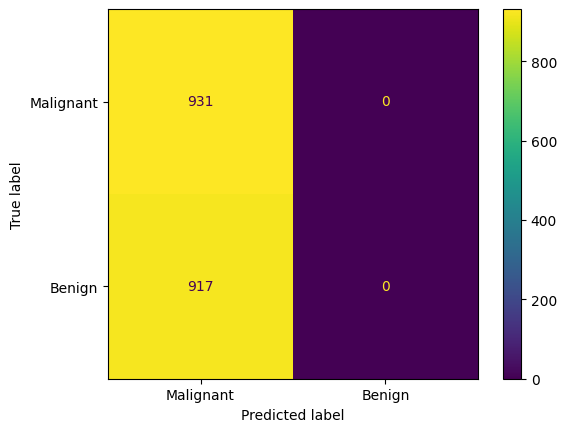

In [ ]:
batch_size = batchsize
predictions = []
actual = []
classes = ['Malignant' ,'Benign']
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        # print(labels)
        # # labels = torch.argmax(labels, dim=0)
        # print(labels)
        outputs = model(images)
        outputs = outputs.logits
        
        _, predicted = torch.max(outputs, 1)
        
        for i in range(batch_size):
          try:
            label = labels[i]
            pred = predicted[i]
            predictions.append(pred.item())
            actual.append(label.item())
          except:
            pass

    cm = confusion_matrix(actual, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()